In [30]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [31]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')

(12, 2) (12, 2)


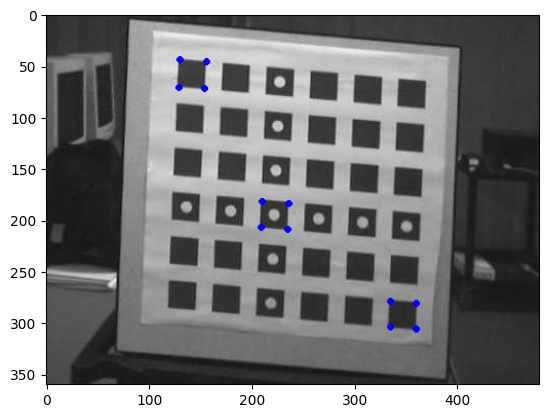

In [32]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (255,0,0), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [33]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# ------------TODO----------------
front_3Dcoord = np.zeros((12, 3))
back_3Dcoord = np.zeros((12, 3))

bias1=[[0,0],[2,3],[5,5]]
bias2=[[0,0],[50,0],[50,50],[0,50]]
for i in range(3):
    for j in range(4):
        front_3Dcoord[i*4+j:]=np.array([bias1[i][0]*80+bias2[j][0],bias1[i][1]*80+bias2[j][1],0])
        back_3Dcoord[i*4+j:]=np.array([bias1[i][0]*80+bias2[j][0],bias1[i][1]*80+bias2[j][1],150])
all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
print(all_2Dcoord.shape, all_3Dcoord.shape)


(24, 2) (24, 3)


In [34]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
# ------------TODO----------------
P = np.zeros((48, 12))
m = np.zeros((12, 1))

for i in range(24):
    P[i*2, 0:3] = all_3Dcoord[i, 0:3]
    P[i*2, 3] = 1
    P[i*2, 8:11] = all_3Dcoord[i, 0:3] * (-all_2Dcoord[i][0])
    P[i*2, 11] = -all_2Dcoord[i][0]
    
    P[i*2+1, 4:7] = all_3Dcoord[i, 0:3]
    P[i*2+1, 7] = 1
    P[i*2+1, 8:11] = all_3Dcoord[i, 0:3] * (-all_2Dcoord[i][1])
    P[i*2+1, 11] = -all_2Dcoord[i][1]
U, S, V = np.linalg.svd(P)
m = V[-1]
#print(m)

In [35]:
# ------------TODO----------------
# Solve K, and [R T] from m
#K=(\alpha,-\alpha cot(theta), uo),(0, \beta/sin(theta), vo),(0,0,1)
#R = [r1, r2, r3], T = [tx, ty, tz]
# ------------TODO----------------
K = np.zeros((3, 3))
R = np.zeros((3, 3))
T = np.zeros((3, 1))

M=np.zeros((3,4))
M[0,:]=m[0:4].T
M[1,:]=m[4:8].T
M[2,:]=m[8:12].T
rho=1.0/np.linalg.norm(M[2,0:3])
cx=(rho**2)*np.dot(M[0,0:3],M[2,0:3])
cy=(rho**2)*np.dot(M[1,0:3],M[2,0:3])
cross1=np.cross(M[0,0:3],M[2,0:3])
cross2=np.cross(M[1,0:3],M[2,0:3])

cross1_tmp=np.cross(M[1,0:3],M[2,0:3])
cross2_tmp=np.cross(M[2,0:3],M[0,0:3])  
cos_theta=np.dot(cross1_tmp,cross2_tmp)/(np.linalg.norm(cross1_tmp)*np.linalg.norm(cross2_tmp))
sin_theta=np.sqrt(1-cos_theta**2)
alpha=(rho**2)*np.linalg.norm(cross1)*sin_theta
beta=rho**2*np.linalg.norm(cross2)*sin_theta
K[0,0]=alpha
K[0,1]=-alpha*cos_theta/sin_theta
K[0,2]=cx
K[1,1]=beta/sin_theta
K[1,2]=cy
K[2,2]=1

R[0,:]=cross1/np.linalg.norm(cross1)
R[2,:]=M[2,0:3]/np.linalg.norm(M[2,0:3])
R[1,:]=np.cross(R[2,:],R[0,:])

T=rho*np.dot(np.linalg.inv(K),M[:,3])




In [36]:
# save results
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
np.save('../results/calibr', save_dict)

# The reference answer of T should be [383001.8386981  -67357.81794783  67071.11338303]
# The results are very strange because the data is fake.